In [ ]:
#| default_exp sampler.subset

In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| export
from qsample.sampler.tree import Tree, Variable, Constant, Delta
import qsample.math as math
import qsample.utils as utils

from qsample.callbacks import CallbackList
from tqdm.auto import tqdm

import numpy as np

In [ ]:
#| export
class SubsetSampler:
    """Class to represent subset sampler
    
    References
    ----------
    ...
    
    Attributes
    ----------
    protocol : Protocol
        Protocol to sample from
    simulator : StabilizerSimulator or StatevectorSimulator
        Simulator used during sampling
    err_model : ErrorModel
        Error model used during sampling
    err_params : dict
        Physical error rates per faulty partition group at which plots generated.
    p_max : dict
        Error probabilities per faulty partition member (one float per member)
    partitions : dict
        Grouping of faulty circuit elements fore each circuit in protocol
    tree : CountTree
        Tree data structure to keep track of sampled events
    """
    def __init__(self, protocol, simulator, p_max, err_model, err_params=None, L=None):
        """
        Parameters
        ----------
        protocol : Protocol
            The protocol to sample from
        simulator : ChpSimulator or StatevectorSimulator
            The simulator used in sampling process
        p_max : dict
            Physical error rates per faulty partition group at which we sample
        err_model : ErrorModel
            Error model used in sampling process
        err_params : dict
            Physical error rates per faulty partition group at which plots generated.
            Should be less than p_max and it should be checked that at p_max all subsets
            scale similar. Only in this region can we use the subset sampler results.
        """
        self.protocol = protocol
        self.simulator = simulator
        self.err_model = err_model()
        self.p_max = self.err_params_to_matrix(p_max)
        self.err_params = self.err_params_to_matrix(err_params)
        
        self.partitions = {cid: self.err_model.group(circuit) for cid, circuit in self.protocol.circuits.items()}
        constants = {cid: math.subset_probs(circuit, self.err_model, self.p_max) for cid, circuit in protocol.circuits.items()}
        self.tree = Tree(constants, L)
      
    def err_params_to_matrix(self, err_params):
        sorted_params = [err_params[k] for k in self.err_model.groups]
        return np.array(np.broadcast_arrays(*sorted_params)).T
        
    def stats(self, err_params=None):
        """Calculate statistics of sample tree wrt `err_params`
        
        Parameters
        ----------
        err_params : dict or None
            Parameter range wrt to which statistics are calculated
        """                    
        _constants = self.tree.constants
        prob = self.err_params if err_params == None else self.err_params_to_matrix(err_params)
        self.tree.constants = {cid: math.subset_probs(circuit, self.err_model, prob) for cid, circuit in self.protocol.circuits.items()}

        
        p_L = self.tree.subtree_sum(self.tree.root, self.tree.marked)
        delta = self.tree.delta
        var = self.tree.var(mode=1)
        var_up = self.tree.var(mode=0)
        
        self.tree.constants = _constants
        return np.broadcast_arrays(p_L, np.sqrt(var), p_L+delta, np.sqrt(var_up))
        
    
    def save(self, path):
        utils.save(path)
        
    def _choose_subset(self, tnode, circuit):
        """Choose a subset for `circuit`, based on current `tnode`
        
        Choice is based on subset occurence probability (Aws).
        Exclude 0-weight-subsets if a circuit is fault-free determinstic and
        the 0-weight-subset has already been sampled in the past.
        
        Parameters
        ----------
        tnode : Variable
            Current tree node we want to sample from
        circuit : Circuit
            Current circuit associated with tree node
        
        Returns
        -------
        tuple
            Next subset to choose for `tnode`
        """
        subsets, Aws = zip(*self.tree.constants[circuit.id].items())
                
        # this doesn't work right: if ff_det the 0-subset would NEVER
        # be selected ever, even though it can lead to a fail eventually.
        # Better: Let the use choose a sampling distribution by setting p_max.
        # Special case: repeat until success -> Here we want to avoid ever going into
        # the 0-subset, but this is not always the case!
        ## Give user choice to omit sampling from 0-subset (default do not)
        
        # if circuit.ff_deterministic and subsets[0] in {n.name for n in tnode.children}:
        #     Aws = np.ma.masked_array(Aws)
        #     Aws[0] = np.ma.masked
        return subsets[ np.random.choice(len(subsets), p=Aws) ]

        
    def run(self, n_shots, callbacks=[]):
        """Execute n_shots of subset sampling
        
        Parameters
        ----------
        n_shots : int
            Number of shots sampled in total
        callbacks : list of Callback
            Callback instances executed during sampling
        """
        self.n_shots = n_shots
        
        if not isinstance(callbacks, CallbackList):
            callbacks = CallbackList(sampler=self, callbacks=callbacks)
        
        self.stop_sampling = False # Flag can be controlled in callbacks
        callbacks.on_sampler_begin()
        
        for _ in tqdm(range(n_shots), desc=f"p={tuple(map('{:.2e}'.format, self.p_max))}"):
            callbacks.on_protocol_begin()
            pnode = self.protocol.root # get protocol start node
            state = self.simulator(len(self.protocol.qubits)) # init state
            msmt_hist = {} # init measurement history
            tnode = None # init tree node
            
            while True:
                callbacks.on_circuit_begin()
                
                pnode, circuit = self.protocol.successor(pnode, msmt_hist)
                tnode = self.tree.add(name=pnode, parent=tnode, node_type=Variable)
                tnode.count += 1
                
                path_weight = self.tree.path_weight(tnode)
                if path_weight == 0:
                    tnode.invariant = True # Nodes along weight-0 path have no variance
                    
                try: # set circuit node invariant if there is only one protocol transition from parent to it
                    tparent = tnode.parent.parent.name
                    if len(list(self.protocol.successors(tparent))) == 1:
                        if tnode.name != "FAIL":
                            tnode.invariant = True
                except:
                    pass
                        
                if circuit:
                
                    # tnode.ff_deterministic = circuit.ff_deterministic
                    tnode.circuit_id = circuit.id
                    
                    if not circuit.noisy:
                        msmt = state.run(circuit)
                        tnode.invariant = True
                        # add 0-subset for not noisy circuits
                        tnode = self.tree.add(name=(0,), parent=tnode, node_type=Constant, const_val=1)
                        tnode.count += 1
                    else:
                            
                        # circuit node
                        if self.protocol.fault_tolerant and self.tree.path_weight(tnode) == 0: # Case IV
                            for virt_sskey in [sskey for sskey in self.tree.constants[circuit.id].keys() if sum(sskey) == 1]: # == 1]: 
                                ss_node = self.tree.add(name=virt_sskey, parent=tnode, node_type=Constant)
                                # expand circuits and subsets for each virtual subset
                                for vcirc_name in [n for n in self.protocol.successors(pnode)]:
                                    circuit_ = self.protocol.get_circuit(vcirc_name)
                                    if circuit_:
                                        if circuit_.noisy:
                                            tnode_ = self.tree.add(name=vcirc_name, parent=ss_node, node_type=Variable, circuit_id=circuit_.id)
                                            # add subsets
                                            for circ_virt_sskey in [sskey for sskey in self.tree.constants[circuit_.id].keys() if sum(sskey) == 0]:
                                                self.tree.add(name=circ_virt_sskey, parent=tnode_, node_type=Constant)
                                            self.tree.add(name='δ', node_type=Delta, parent=tnode_)
                        self.tree.add(name='δ', node_type=Delta, parent=tnode)
             
                        subset = self._choose_subset(tnode, circuit)
                        fault_locs = self.err_model.choose_w(self.partitions[circuit.id], subset)
                        fault_circuit = self.err_model.run(circuit, fault_locs)
                        msmt = state.run(circuit, fault_circuit)
                                    
                        tnode = self.tree.add(name=subset, parent=tnode, node_type=Constant)
                        tnode.count += 1
                        
                        # subset node
                        path_weight = self.tree.path_weight(tnode)
                        if path_weight == 0: # Case I
                            pass
                        else:
                            if self.protocol.fault_tolerant:
                                smallest_failure_exponent = 2
                            else:
                                smallest_failure_exponent = 1
                            

                            if self.protocol.fault_tolerant and path_weight == 1: # case III
                                delta_value = None
                            elif path_weight >= smallest_failure_exponent: # case II
                                delta_value = 1
                            # add virtual circuit and its delta
                            # print([n for n in self.protocol.successors(pnode) if n != tnode.parent.name])
                            
                            # other = [n for n in self.protocol.successors(pnode) if n != tnode.parent.name][0] # other circuit from protocol
                            # print(repr(tnode), list(self.protocol.successors(pnode)), other)
                            for vcirc_name in self.protocol.successors(pnode):
                                circuit_ = self.protocol.get_circuit(vcirc_name)

                                # if other_circuit.noisy:
                                if circuit_:
                                    # print('circ:', other)
                                    tnode_ = self.tree.add(name=vcirc_name, parent=tnode, node_type=Variable, circuit_id=circuit_.id)
                                    delta_ = self.tree.add(name='δ', node_type=Delta, parent=tnode_)
                                    delta_.value = delta_value # custom delta value

                    msmt = msmt if msmt==None else int(msmt,2) # convert to int for comparison in checks
                    msmt_hist[pnode] = msmt_hist.get(pnode, []) + [msmt]
                else:
                    if path_weight <= (1 if self.protocol.fault_tolerant else 0):
                        # Leaf nodes of fault tolerant paths have not variance
                        tnode.invariant = True
                    if pnode != None:
                        # "Interesting" event happened
                        self.tree.marked.add(tnode)
                    break

                callbacks.on_circuit_end(locals())
                
            callbacks.on_protocol_end()
            if self.stop_sampling:
                break
        del self.stop_sampling
        callbacks.on_sampler_end()

p=('1.00e-02', '1.00e-02'):   0%|          | 0/100 [00:00<?, ?it/s]

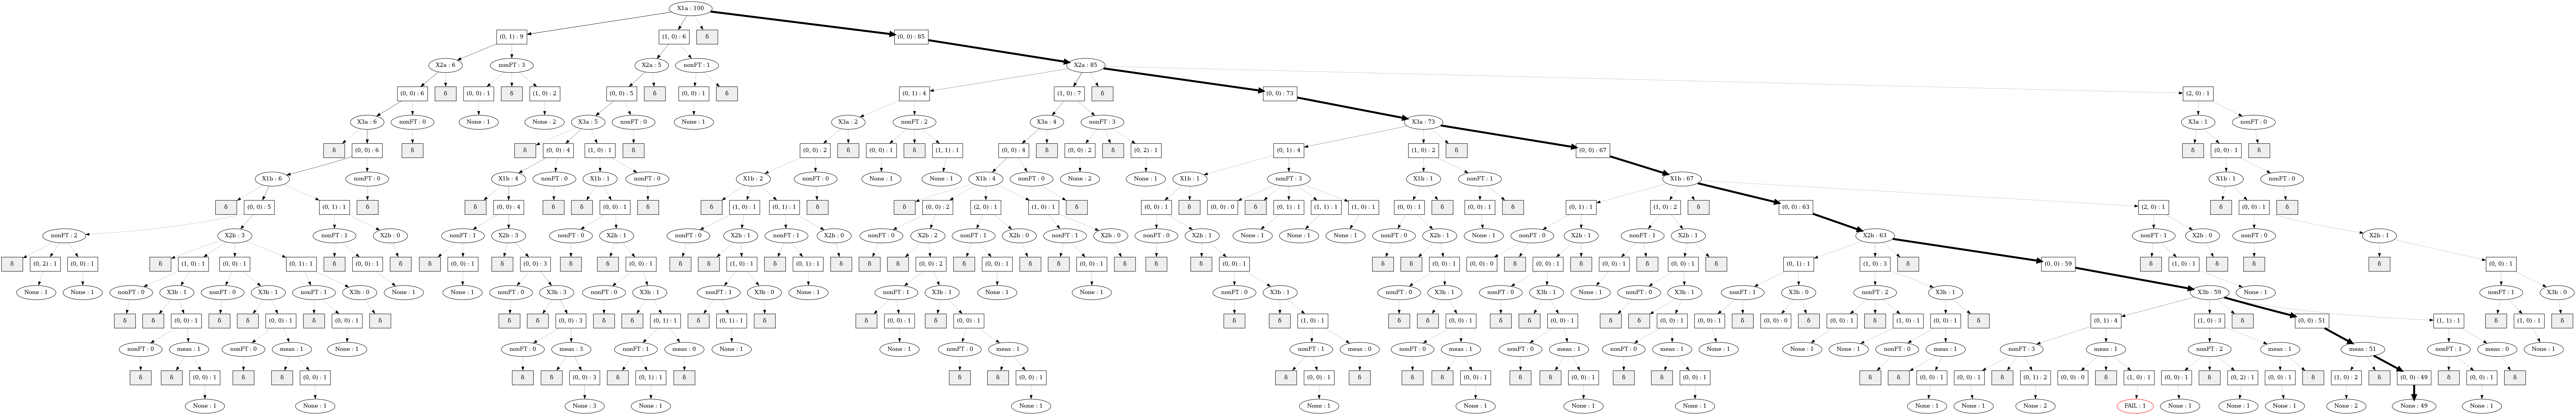

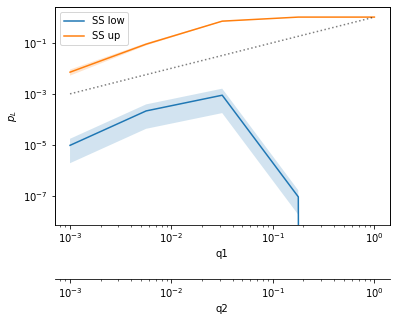

In [ ]:
#| slow

from qsample.examples import ghz1, ghz3, ghz_stab, ftsteane, flagstab, steane0, tele
from qsample.sim.stabilizer import StabilizerSimulator as CHP
from qsample.noise import E1, E1_1, S2
import qsample.callbacks as cb
from qsample.sampler.experimental import SubsetSamplerERV

# steane0.draw()
# steane0.nodes('X_COR')
# steane0.circuits
sample_range = np.logspace(-3,0,5)
# err_params = {'q': sample_range}
# p_max = {'q': 1e-2}

# err_params = {'q1': sample_range, 'q2': sample_range}
# p_max = {'q1': 1e-2, 'q2': 1e-2}

ss_sam = SubsetSampler(protocol=flagstab, simulator=CHP,  p_max=p_max, err_model=S2, err_params=err_params, L=2)
ss_sam.run(100, callbacks=[cb.PlotStats()])

ss_sam.tree.draw(verbose=True)
# print(ss_sam.tree)